In [1]:
import pandas as pd

train = pd.read_excel("time_series_375_preprocess_en.xlsx")
test = pd.read_excel("time_series_test_110_preprocess_en.xlsx")

train['PATIENT_ID'] = train['PATIENT_ID'].ffill()
test['PATIENT_ID'] = test['PATIENT_ID'].ffill()

# use first admission and last discharge per patient
train_times = train.groupby('PATIENT_ID').agg({
    'Admission time': 'first',
    'Discharge time': 'last'
}).reset_index()
train_times['stay_duration_days'] = (
    (train_times['Discharge time'] - train_times['Admission time']).dt.total_seconds() / (24 * 60 * 60)
)
train_duration = train_times[['PATIENT_ID', 'stay_duration_days']]

test_times = test.groupby('PATIENT_ID').agg({
    'Admission time': 'first',
    'Discharge time': 'last'
}).reset_index()
test_times['stay_duration_days'] = (
    (test_times['Discharge time'] - test_times['Admission time']).dt.total_seconds() / (24 * 60 * 60)
)
test_duration = test_times[['PATIENT_ID', 'stay_duration_days']]

exclude_cols = ['PATIENT_ID', 'outcome']
labs_to_agg_train = train.select_dtypes(include='number').columns.difference(exclude_cols + ['stay_duration_days'])
labs_to_agg_test = test.select_dtypes(include='number').columns.difference(exclude_cols + ['stay_duration_days'])

agg_funcs = ['mean', 'min', 'max', 'last']

train_agg = train.groupby('PATIENT_ID')[labs_to_agg_train].agg(agg_funcs)
train_agg.columns = ['_'.join(col).strip() for col in train_agg.columns.values]
train_agg.reset_index(inplace=True)

# patient level outcome
train_outcome = train[['PATIENT_ID', 'outcome']].drop_duplicates(subset='PATIENT_ID')

train_final = train_agg.merge(train_outcome, on='PATIENT_ID', how='left')
train_final = train_final.merge(train_duration, on='PATIENT_ID', how='left')

test_agg = test.groupby('PATIENT_ID')[labs_to_agg_test].agg(agg_funcs)
test_agg.columns = ['_'.join(col).strip() for col in test_agg.columns.values]
test_agg.reset_index(inplace=True)

test_outcome = test[['PATIENT_ID', 'outcome']].drop_duplicates(subset='PATIENT_ID')

test_final = test_agg.merge(test_outcome, on='PATIENT_ID', how='left')
test_final = test_final.merge(test_duration, on='PATIENT_ID', how='left')

X_train = train_final.drop(columns=['PATIENT_ID', 'outcome'])
y_train = train_final['outcome']

X_test = test_final.drop(columns=['PATIENT_ID', 'outcome'])
y_test = test_final['outcome']

common_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_cols]
X_test = X_test[common_cols]

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("Missing in train:", X_train.isnull().sum().sum())
print("Missing in test :", X_test.isnull().sum().sum())
print("Unique patients in train:", len(X_train))
print("Unique patients in test :", len(X_test))

print("\nSample of cleaned training data:")
print(X_train.head())
print(y_train.head())


X_train shape: (375, 13)
X_test shape : (110, 13)
Missing in train: 0
Missing in test : 0
Unique patients in train: 375
Unique patients in test : 110

Sample of cleaned training data:
   (%)lymphocyte_mean  (%)lymphocyte_min  (%)lymphocyte_max  \
0           22.720000               10.5               28.7   
1           13.650000                7.5               24.3   
2           26.500000               19.1               33.1   
3           18.250000               12.5               22.5   
4           30.666667               23.6               37.9   

   (%)lymphocyte_last  Hypersensitive c-reactive protein_mean  \
0                25.9                               16.433333   
1                 9.2                               27.400000   
2                27.3                               22.950000   
3                16.5                               61.350000   
4                23.6                                3.900000   

   Hypersensitive c-reactive protein_min  \
0 


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        97
           1       0.85      0.85      0.85        13

    accuracy                           0.96       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.96      0.96      0.96       110

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        97
           1       0.83      0.77      0.80        13

    accuracy                           0.95       110
   macro avg       0.90      0.87      0.89       110
weighted avg       0.95      0.95      0.95       110



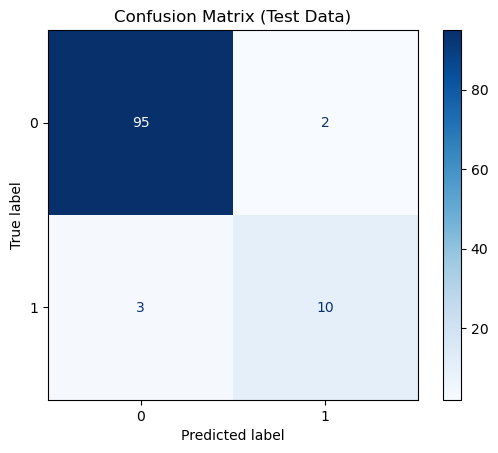


=== Train ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00       174

    accuracy                           1.00       375
   macro avg       1.00      1.00      1.00       375
weighted avg       1.00      1.00      1.00       375

AUC: 1.00

=== Test ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        97
           1       0.85      0.85      0.85        13

    accuracy                           0.96       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.96      0.96      0.96       110

AUC: 0.99
=== Cross-Validation Metrics Per Fold ===
   Fold    AUC     F1  Recall  Precision
0     1  0.996  0.970   0.941      1.000
1     2  0.998  0.972   1.000      0.946
2     3  0.966  0.904   0.943      0.868
3     4  0.964  0.932   0.971      0.895
4     5  0.988  0.957   0.943      0.971

=== Mean

In [2]:
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=100,     
    max_depth=None,        
    class_weight='balanced_subsample',
    random_state=42,      
    n_jobs=-1             
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("\nClassification Report")
print(classification_report(y_test, y_pred))


y_probs = rf.predict_proba(X_test)[:, 1] 
y_pred = (y_probs >= 0.6).astype(int)  # 0.6 threshold instead of 0.5 to improve recall

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Data)")
plt.show()

for name, X, y in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
    y_pred = rf.predict(X)
    y_prob = rf.predict_proba(X)[:, 1]
    print(f"\n=== {name} ===")
    print(classification_report(y, y_pred))
    print(f"AUC: {roc_auc_score(y, y_prob):.2f}")

    
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

scores = cross_validate(rf, X_train, y_train, scoring=scoring, cv=cv, return_train_score=False)

fold_results = pd.DataFrame({
    'Fold': range(1, len(scores['test_auc']) + 1),
    'AUC': scores['test_auc'],
    'F1': scores['test_f1'],
    'Recall': scores['test_recall'],
    'Precision': scores['test_precision']
})

print("=== Cross-Validation Metrics Per Fold ===")
print(fold_results.round(3))

print("\n=== Mean ± Std ===")
print(fold_results.mean().round(3).to_frame('Mean').T)
print(fold_results.std().round(3).to_frame('Std').T)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 174, number of negative: 201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 375, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

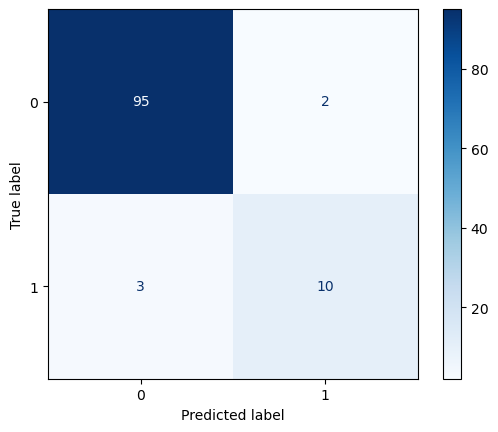

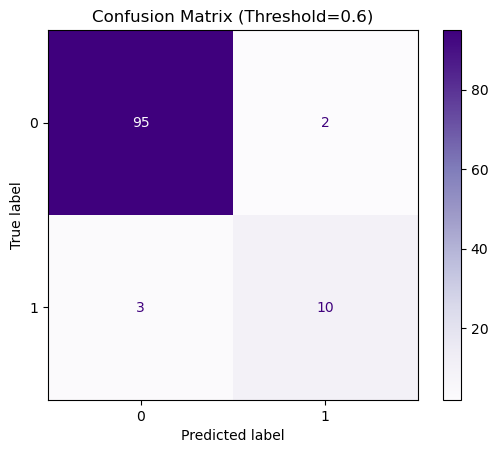


=== Train ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       201
           1       0.96      0.99      0.97       174

    accuracy                           0.98       375
   macro avg       0.98      0.98      0.98       375
weighted avg       0.98      0.98      0.98       375

AUC: 1.00

=== Test ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        97
           1       0.83      0.77      0.80        13

    accuracy                           0.95       110
   macro avg       0.90      0.87      0.89       110
weighted avg       0.95      0.95      0.95       110

AUC: 0.99
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 140, number of negative: 160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020323 seconds.
You can set `force_col_wise=true` to remove th

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [3]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.base import clone

lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:,1]

print("\n=== LightGBM ===")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")

import numpy as np

# try lowering threshold to favor recall for class 1
custom_thresh = 0.60 
y_pred = (y_prob >= custom_thresh).astype(int)

print(f"\n=== With Custom Threshold = {custom_thresh} ===")
print(classification_report(y_test, y_pred))

cm_thresh = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_thresh).plot(cmap="Purples")
plt.title(f"Confusion Matrix (Threshold={custom_thresh})")
plt.show()

for name, X, y in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
    y_pred = lgbm.predict(X)
    y_prob = lgbm.predict_proba(X)[:, 1]
    print(f"\n=== {name} ===")
    print(classification_report(y, y_pred))
    print(f"AUC: {roc_auc_score(y, y_prob):.2f}")

    
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

scores = cross_validate(clone(lgbm), X_train, y_train, scoring=scoring, cv=cv, return_train_score=False)

fold_results = pd.DataFrame({
    'Fold': range(1, len(scores['test_auc']) + 1),
    'AUC': scores['test_auc'],
    'F1': scores['test_f1'],
    'Recall': scores['test_recall'],
    'Precision': scores['test_precision']
})

print("=== Cross-Validation Metrics Per Fold ===")
print(fold_results.round(3))

print("\n=== Mean ± Std ===")
print(fold_results.mean().round(3).to_frame('Mean').T)
print(fold_results.std().round(3).to_frame('Std').T)


=== Top Features according to LightGBM ===
                                   Feature  Importance
11              Lactate dehydrogenase_last          80
5    Hypersensitive c-reactive protein_min          76
12                      stay_duration_days          63
3                       (%)lymphocyte_last          53
7   Hypersensitive c-reactive protein_last          52
4   Hypersensitive c-reactive protein_mean          29
1                        (%)lymphocyte_min          27
2                        (%)lymphocyte_max          27
10               Lactate dehydrogenase_max          27
6    Hypersensitive c-reactive protein_max          22
8               Lactate dehydrogenase_mean          22
0                       (%)lymphocyte_mean          19
9                Lactate dehydrogenase_min          13


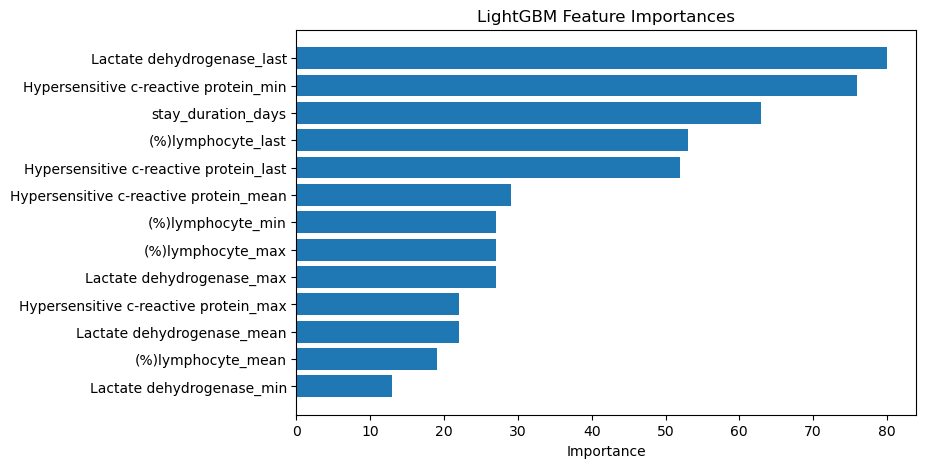

In [4]:
# feature importance
importances = lgbm.feature_importances_
features = X_train.columns

imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n=== Top Features according to LightGBM ===")
print(imp_df)

plt.figure(figsize=(8, 5))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


Permutation Importance:
                                    Feature  Importance
11              Lactate dehydrogenase_last    0.135455
7   Hypersensitive c-reactive protein_last    0.002727
0                       (%)lymphocyte_mean    0.000000
1                        (%)lymphocyte_min    0.000000
2                        (%)lymphocyte_max    0.000000
3                       (%)lymphocyte_last    0.000000
4   Hypersensitive c-reactive protein_mean    0.000000
6    Hypersensitive c-reactive protein_max    0.000000
8               Lactate dehydrogenase_mean    0.000000
9                Lactate dehydrogenase_min    0.000000
10               Lactate dehydrogenase_max    0.000000
5    Hypersensitive c-reactive protein_min   -0.001818
12                      stay_duration_days   -0.002727


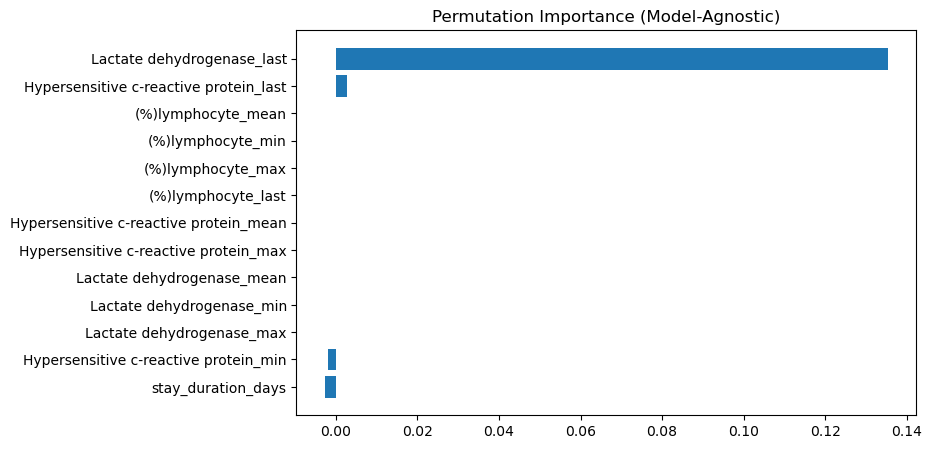

In [5]:
# permutation importance 
from sklearn.inspection import permutation_importance

perm = permutation_importance(lgbm, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance:\n", perm_df)

plt.figure(figsize=(8, 5))
plt.barh(perm_df['Feature'], perm_df['Importance'])
plt.title("Permutation Importance (Model-Agnostic)")
plt.gca().invert_yaxis()
plt.show()


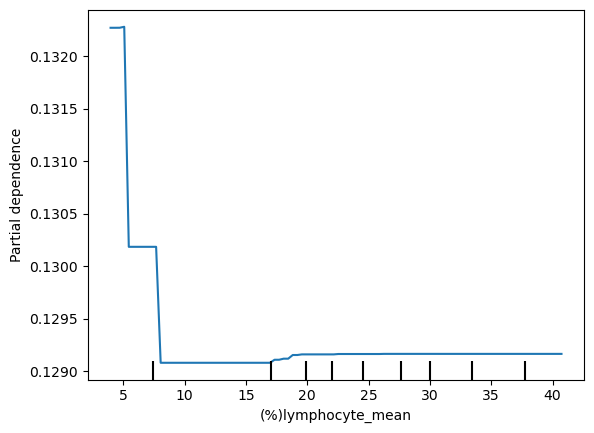

In [6]:
# PDP for lymphocyte_mean
from sklearn.inspection import PartialDependenceDisplay


feature_to_plot = '(%)lymphocyte_mean'

PartialDependenceDisplay.from_estimator(
    lgbm,
    X_test,
    features=[feature_to_plot],  
    kind="average"
)


 TreeSHAP Global Summary Plot (Class 1)


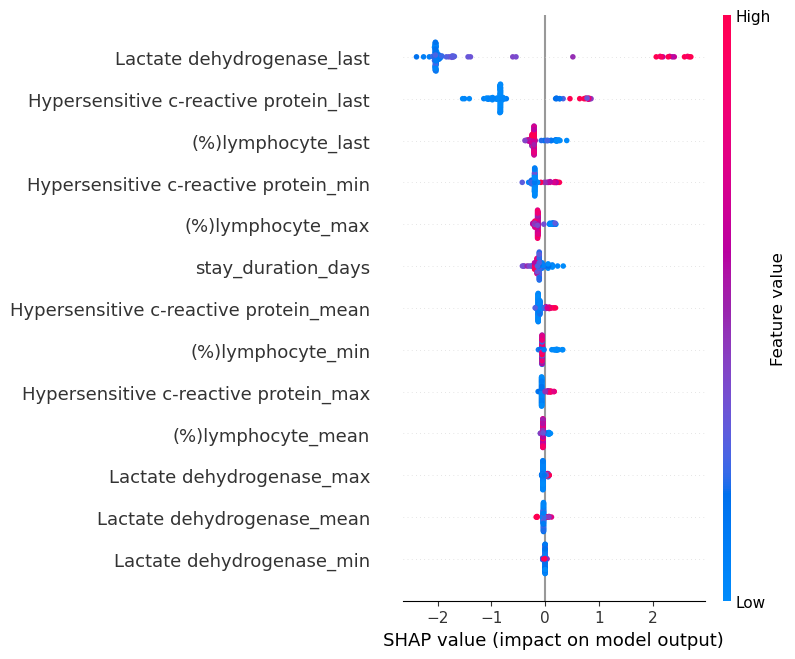

In [7]:
# TreeSHAP global explanation
import shap

explainer = shap.Explainer(lgbm, X_train)

shap_values_all = explainer(X_test, check_additivity=False)

print("\n TreeSHAP Global Summary Plot (Class 1)")
shap.summary_plot(shap_values_all.values, X_test)

## Local

In [8]:
y_true = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)

TP_mask = (y_true == 1) & (y_pred == 1)
TN_mask = (y_true == 0) & (y_pred == 0)
FP_mask = (y_true == 0) & (y_pred == 1)
FN_mask = (y_true == 1) & (y_pred == 0)

TP_idx = TP_mask[TP_mask].index[0]
TN_idx = TN_mask[TN_mask].index[0]
FP_idx = FP_mask[FP_mask].index[0]
FN_idx = FN_mask[FN_mask].index[0]

print(f"TP index: {TP_idx}, TN index: {TN_idx}, FP index: {FP_idx}, FN index: {FN_idx}")


TP index: 2, TN index: 0, FP index: 39, FN index: 27



TreeSHAP Force Plot for TP (Index 2)


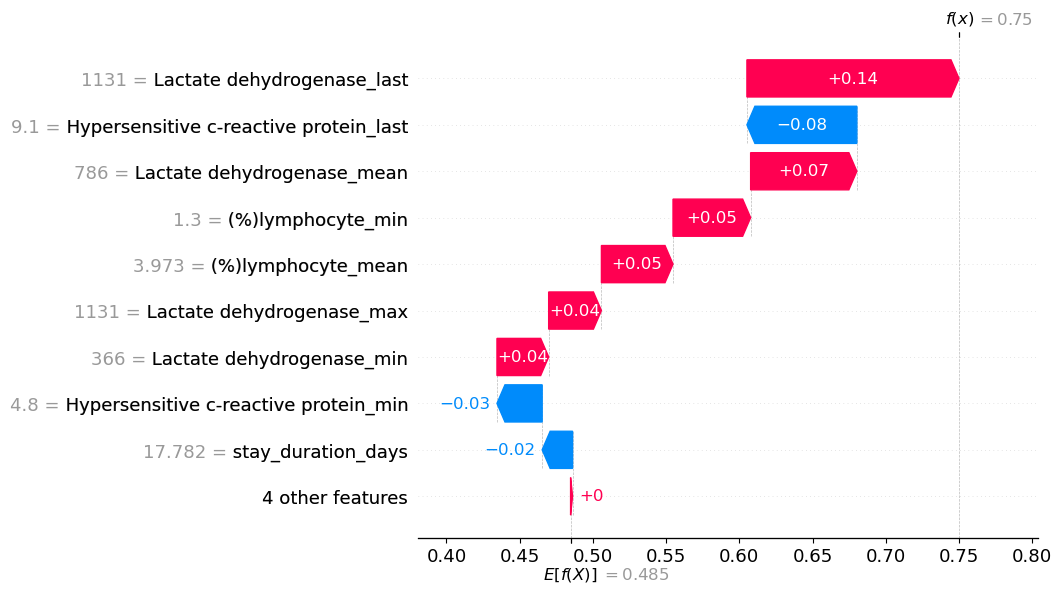


TreeSHAP Force Plot for TN (Index 0)


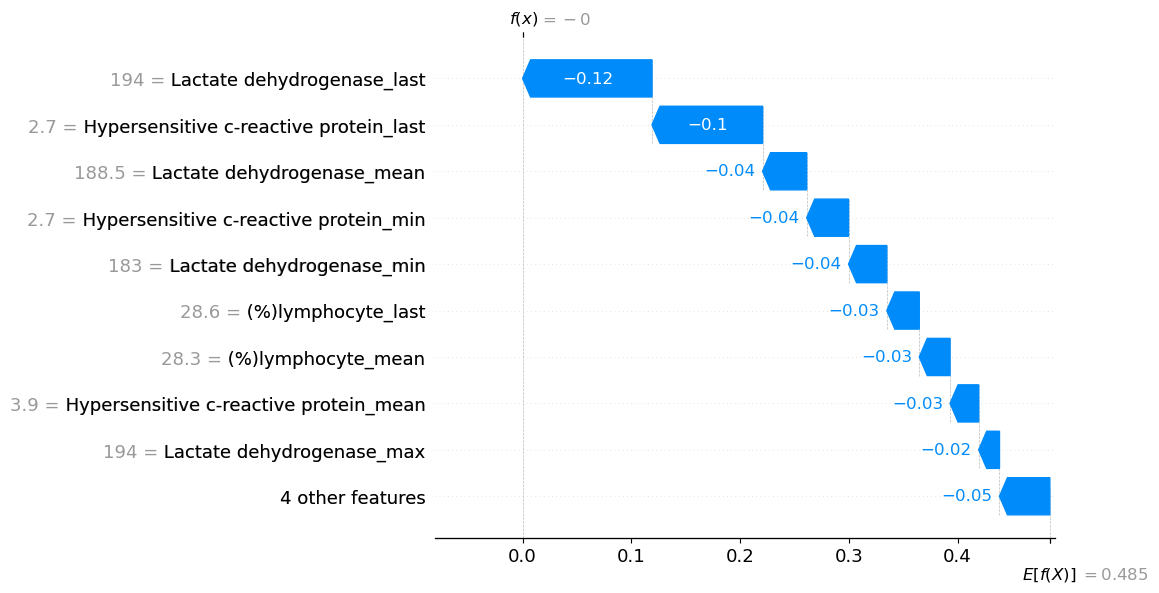


TreeSHAP Force Plot for FP (Index 39)


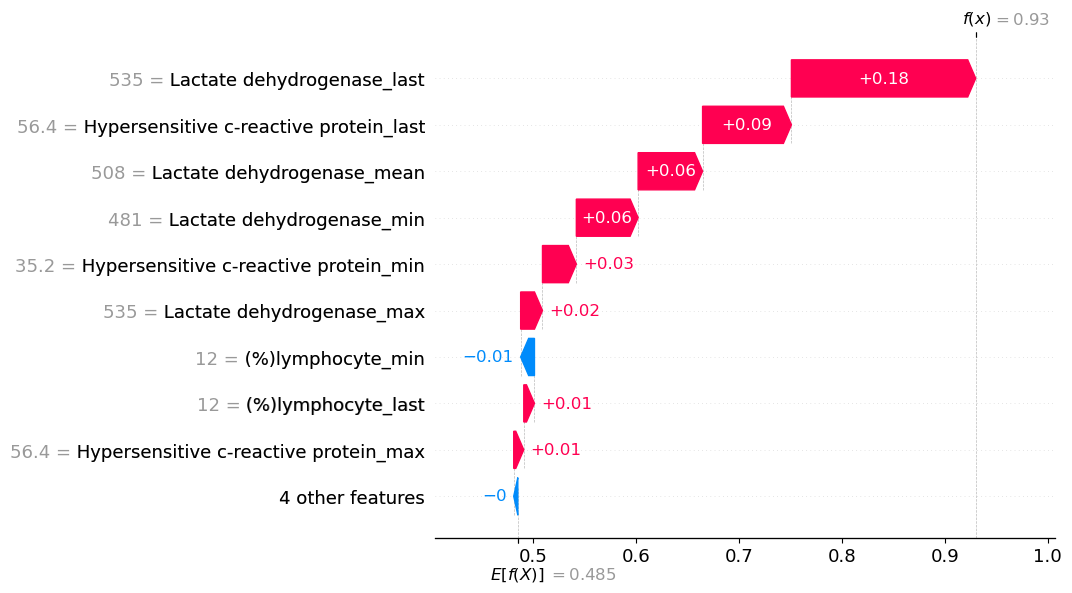


TreeSHAP Force Plot for FN (Index 27)


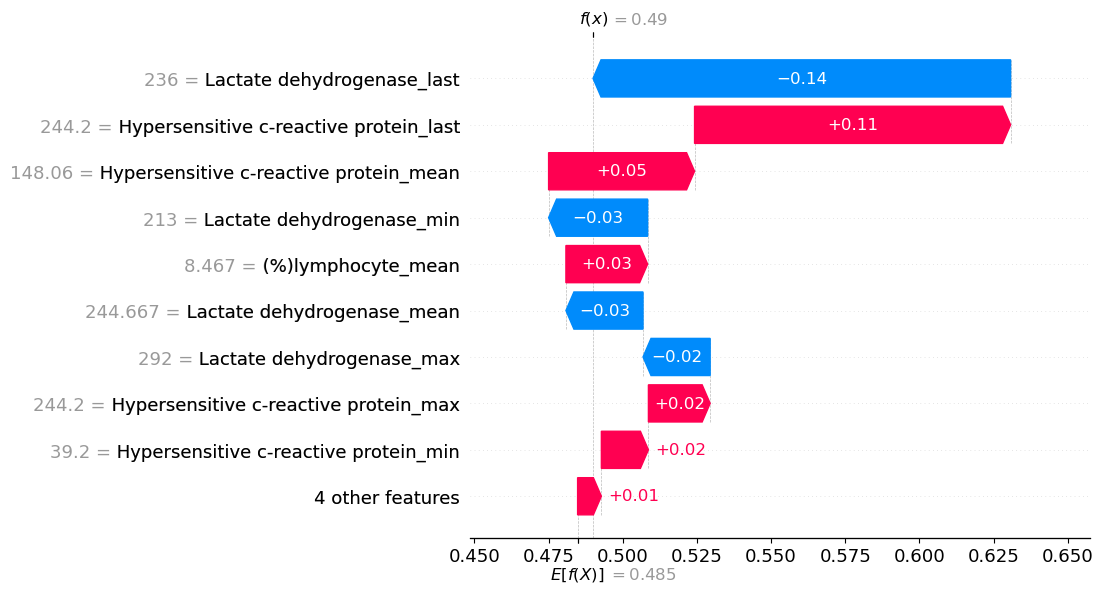

In [9]:
# TreeSHAP local explanations

import shap

explainer = shap.Explainer(rf, X_train)

sample_dict = {
    "TP": TP_idx,
    "TN": TN_idx,
    "FP": FP_idx,
    "FN": FN_idx
}

for label, idx in sample_dict.items():
    x_single = X_test.iloc[[idx]]
    shap_value = explainer(x_single)
    print(f"\nTreeSHAP Force Plot for {label} (Index {idx})")

    shap.plots.waterfall(shap_value[0, :, 1]) 


In [10]:
# LIME 
import lime
import lime.lime_tabular

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Survived', 'Died'],
    mode='classification'
)

for label, idx in sample_dict.items():
    print(f"\nLIME Explanation for {label} (Index {idx})")

    lime_exp = lime_explainer.explain_instance(
        data_row=X_test.iloc[idx],
        predict_fn=lambda x: rf.predict_proba(pd.DataFrame(x, columns=X_test.columns))
    )

    try:
        lime_exp.show_in_notebook(show_table=True)
    except ImportError:
        html_exp = lime_exp.as_html()
        with open(f'lime_{label}.html', 'w') as f:
            f.write(html_exp)
        print(f"LIME explanation saved to lime_{label}.html")

    print(lime_exp.as_list())

    


LIME Explanation for TP (Index 2)


[('Lactate dehydrogenase_last > 598.00', 0.2103734245735219), ('Lactate dehydrogenase_mean > 590.70', 0.08098638833612294), ('2.25 < Hypersensitive c-reactive protein_last <= 26.30', -0.07120159488734078), ('(%)lymphocyte_mean <= 5.34', 0.061468045526823056), ('(%)lymphocyte_min <= 3.50', 0.04980321109376853), ('2.25 < Hypersensitive c-reactive protein_min <= 21.50', -0.0415553246515492), ('264.50 < Lactate dehydrogenase_min <= 490.00', 0.03132201585802566), ('Lactate dehydrogenase_max > 661.00', 0.0285011700591796), ('11.75 < Hypersensitive c-reactive protein_mean <= 49.00', -0.02059348960557537), ('18.70 < Hypersensitive c-reactive protein_max <= 62.80', -0.015310687277518673)]

LIME Explanation for TN (Index 0)


[('Lactate dehydrogenase_last <= 201.50', -0.16194852687348857), ('2.25 < Hypersensitive c-reactive protein_last <= 26.30', -0.07398159417342476), ('Lactate dehydrogenase_mean <= 226.25', -0.05716931284321422), ('Lactate dehydrogenase_min <= 192.00', -0.05668550820944478), ('(%)lymphocyte_last > 27.15', -0.05512787900307251), ('(%)lymphocyte_mean > 25.70', -0.04494081238342925), ('Hypersensitive c-reactive protein_mean <= 11.75', -0.04131308414134261), ('2.25 < Hypersensitive c-reactive protein_min <= 21.50', -0.037403608689702175), ('Lactate dehydrogenase_max <= 256.00', -0.027594947078669437), ('Hypersensitive c-reactive protein_max <= 18.70', -0.026618872872039113)]

LIME Explanation for FP (Index 39)


[('273.50 < Lactate dehydrogenase_last <= 598.00', 0.1512587307627267), ('26.30 < Hypersensitive c-reactive protein_last <= 96.20', 0.06770196525279204), ('306.43 < Lactate dehydrogenase_mean <= 590.70', 0.05750665401896343), ('264.50 < Lactate dehydrogenase_min <= 490.00', 0.051913624021289455), ('14.70 < (%)lymphocyte_mean <= 25.70', -0.034455337545908016), ('21.50 < Hypersensitive c-reactive protein_min <= 73.00', 0.031200278954198257), ('10.30 < (%)lymphocyte_min <= 21.05', -0.01891229395578045), ('11.75 < Hypersensitive c-reactive protein_mean <= 49.00', -0.01587082060518042), ('18.85 < (%)lymphocyte_max <= 31.05', -0.014092248018423355), ('368.00 < Lactate dehydrogenase_max <= 661.00', 0.01353646447726516)]

LIME Explanation for FN (Index 27)


[('Hypersensitive c-reactive protein_last > 96.20', 0.15815096110233007), ('201.50 < Lactate dehydrogenase_last <= 273.50', -0.15757129270317344), ('226.25 < Lactate dehydrogenase_mean <= 306.43', -0.06616016345179263), ('192.00 < Lactate dehydrogenase_min <= 264.50', -0.04711791116021088), ('Hypersensitive c-reactive protein_mean > 112.80', 0.036420487719693674), ('21.50 < Hypersensitive c-reactive protein_min <= 73.00', 0.028313900835327435), ('256.00 < Lactate dehydrogenase_max <= 368.00', -0.018605716417160276), ('Hypersensitive c-reactive protein_max > 144.40', 0.018456602056368725), ('9.59 < stay_duration_days <= 15.69', -0.017577957515659087), ('5.34 < (%)lymphocyte_mean <= 14.70', 0.015810677912907474)]


In [11]:
#CO-12
x_orig = X_test.iloc[[TP_idx]]
shap_orig = explainer(x_orig)

x_noisy = x_orig.copy()
x_noisy *= (1 + 0.01)  # 1% increase
shap_noisy = explainer(x_noisy)

diff = np.abs(shap_orig.values - shap_noisy.values)
mean_diff = diff.mean()

print(f"Average change in SHAP values after small input perturbation: {mean_diff:.4f}")


Average change in SHAP values after small input perturbation: 0.0015
